# Bayesian SIR

Antonio Feltrin, Giosuè Sardo Infirri, Riccardo Tancredi, Simone Toso


## Scaletta
 - SIMULARE DATI --> Fatto
 - MCMC con un solo parametro

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.special import gamma as gammafunc
from scipy.stats import gamma as gammadist

## Data generation

In [2]:
#Parameter initialization
N = int(1e6)
T = 100
I0 = 50
beta_true = 0.3
gamma_true = 0.05

betas = 100*[beta_true]
gammas = 100*[gamma_true]

#Simulation
initial_conf = np.array([N-I0, I0, 0])

configurations = np.zeros([T, 3])
configurations[0, :] = initial_conf

for tt in range(1, T):
    beta_true = betas[tt]
    gamma_true = gammas[tt]
    
    delta_I = npr.binomial(configurations[tt-1][0],
                           1 - np.exp(-beta_true*configurations[tt-1][1]/N))
    delta_R = npr.binomial(configurations[tt-1][1],
                           gamma_true)
    configurations[tt][0] = configurations[tt-1][0] - delta_I
    configurations[tt][1] = configurations[tt-1][1] + delta_I - delta_R
    configurations[tt][2] = configurations[tt-1][2] + delta_R

Text(0.5, 1.0, 'Simulated data with varying parameters')

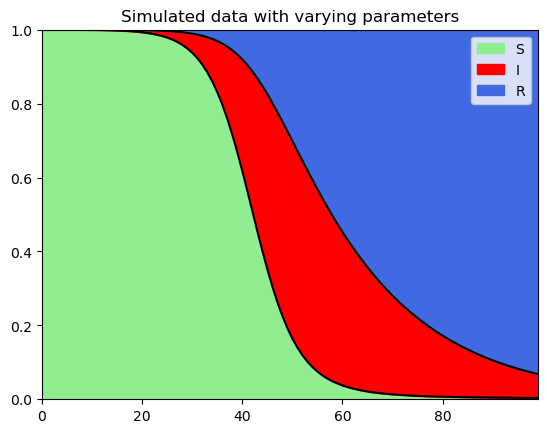

In [3]:
xs = np.arange(0, T)
ss = configurations[:, 0] / N
ii = configurations[:, 1]/N + ss
rr = configurations[:, 2]/N + ii

plt.plot(ss, c = "black")
plt.plot(ii, c = "black")
plt.plot(rr, c = "black")
plt.ylim([0, 1])

plt.fill_between(xs, 0, ss, label = "S", color = "lightgreen")
plt.fill_between(xs, ss, ii, label = "I", color = "red")
plt.fill_between(xs, ii, rr, label = "R", color = "royalblue")

plt.xlim([0, T-1])
plt.legend()
plt.title("Simulated data with varying parameters")

## MCMC

 - Update delta
 - Update b,r
 - Update gamma

In [9]:
def mylog(x):
    res = np.where(x != 0, np.log(x), -1022)
    return res


In [10]:
def conditional_betagamma(delta, beta, gamma):
    K = np.sum(delta).astype(int)
    eta = np.cumsum(delta)
    total = 0
    for ii in range(K):
        total += 2*mylog(gammafunc(0.1 + np.sum(eta == K)))
        #print("A", total, 0.1 + np.sum(beta*(eta==K)), 0.1 + np.sum(eta == K))
        total -= mylog(0.1 + np.sum(beta*(eta==K)))*(0.1 + np.sum(eta == K))
        #print("B", total, 0.1 + np.sum(beta*(eta==K)), 0.1 + np.sum(eta == K))
        #print("GAMMA", gamma)
        #print("LogGamma", mylog(gamma))
        total -= mylog(0.1 - np.sum(mylog(gamma)*(eta==K)))*(0.1 + np.sum(eta == K))
        #print("C", total, 0.1 + np.sum(beta*(eta==K)), 0.1 + np.sum(eta == K))
    return total

In [11]:
def JJ(delta_proposed, delta_now, T):
    
    sum_proposed = np.sum(delta_proposed).astype(int)
    sum_now = np.sum(delta_now).astype(int)
    
    if sum_proposed == sum_now:
        return 1
    elif sum_proposed == 1 and sum_now == 2:
        return 3/(T-1)
    elif sum_proposed == T and sum_now == T-1:
        return 3/(T-1)
    elif sum_proposed == 2 and sum_now == 1:
        return (T-1)/3
    elif sum_proposed == T-1 and sum_now == T:
        return (T-1)/3
    elif sum_proposed < sum_now:
        return (sum_now - 1)/(T-sum_proposed)
    else:
        return (T- sum_now) / (sum_proposed - 1)
    
def update_delta(delta_proposed, delta_now, beta_now, gamma_now, p, T):
    #Step 1: evaluate first term pi/pi
    difference = np.sum(delta_proposed - delta_now)
    first_term = difference*mylog(p/(1-p))
    
    #Step 2: evaluate second term:
    second_term = conditional_betagamma(delta_proposed, beta_now, gamma_now)
    second_term -= conditional_betagamma(delta_now, beta_now, gamma_now)
    
    #Step 3: evaluate third term
    third_term = mylog(JJ(delta_proposed, delta_now, T))
    
    log_m = first_term + second_term + third_term
    print("log_m is: ", log_m)
    
    probability = np.exp(min(0, log_m))
    print("probability is: ", probability)
    
    eps = npr.uniform() 
    if eps < probability:
        print("Accepting")
        return delta_proposed
    else:
        return delta_now

In [12]:
def propose_delta(delta_now, T):
    K = np.sum(delta_now).astype(int)
    delta = delta_now.copy()
    if K == 1:
        probs = np.array([1,0,0])
    elif K==T:
        probs = np.array([0,1,0])
    else:
        probs = np.array([1,1,1])/3
        
    choice = npr.choice([0,1,2], p = probs)
    
    if choice == 0: #add
        index = npr.choice(np.where(delta_now == 0)[0])
        delta[index] += 1
    elif choice == 1: #delete
        index = npr.choice(np.where(delta_now == 1)[0])
        delta[index] -= 1
    else:
        index_0 = npr.choice(np.where(delta_now == 0)[0])
        index_1 = npr.choice(np.where(delta_now == 1)[0])
        delta[index_0] = 1
        delta[index_1] = 0
    
    return delta   

In [21]:
# Try one step
p = .01
T = 100

# Initialize delta
delta_0 = (npr.uniform(size = T) < p).astype(int)
delta_0[0] = 1

KK = np.sum(delta_0)
eta = np.cumsum(delta_0)
rb = npr.gamma(shape = .1, scale = 10, size = (2,KK))
r_0 = rb[0]
b_0 = rb[1]

r_0 = r_0[eta-1]
b_0 = b_0[eta-1]

beta_0 = npr.exponential(1/b_0)
gamma_0 = npr.beta(r_0, 1)

print("GAMMA_0", gamma_0)

delta_1 = propose_delta(delta_0, T)
prova = update_delta(delta_1, delta_0, beta_0, gamma_0, p, T)


GAMMA_0 [3.14033137e-025 1.69757461e-015 2.03778992e-013 8.24591991e-055
 6.64859348e-015 2.80371629e-017 1.17703470e-130 7.72642246e-150
 2.91656454e-010 7.57344076e-003 1.09977571e-003 6.40477348e-036
 1.40129312e-007 1.37458392e-024 1.39598027e-030 1.53976326e-032
 5.09301716e-125 1.70275123e-016 6.82027036e-034 7.76012529e-005
 4.98293387e-007 1.66844682e-023 3.62619676e-037 1.58011279e-021
 6.02071812e-034 5.17772630e-074 3.44602391e-036 4.80808336e-021
 2.32972085e-001 1.06209181e-010 5.79315525e-006 6.65611940e-005
 1.50803661e-019 2.92087402e-002 1.33000224e-013 6.58071129e-022
 7.34330467e-021 1.10941383e-072 1.70969768e-026 4.45698642e-034
 8.88599147e-018 9.75495232e-003 7.70677306e-034 1.14611155e-018
 7.42810634e-019 2.60463155e-039 2.26119110e-040 6.48733660e-009
 4.21624294e-041 2.57322791e-008 2.82391396e-123 1.22295646e-008
 5.04306946e-001 4.87781437e-011 1.26135013e-004 1.00286153e-001
 3.67248308e-004 1.75993692e-025 4.69420514e-092 5.03983644e-051
 2.58523376e-028 